Evaluate a model

In [222]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import agent as rl

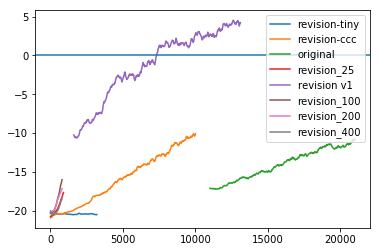

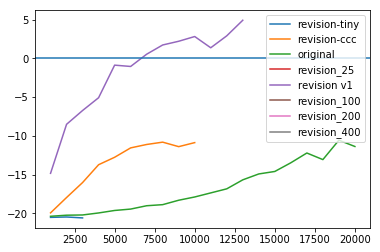

In [223]:
def show_model_activations(model):
    
    # just one neuron is enough.
    for i in range(1):
        plt.imshow(model["W1"][i,:].reshape((80,80)))
        plt.colorbar()
        plt.show()    
    plt.plot(model['W2'])
    plt.show()

    
def format_score(score):
    return "{0:.1f} ± {1:.1f} [95% CI]".format(score[1], 1.96 * score[2])


def smooth(data, lam = 0.90):
    y = data[0]
    result = []
    for x in data:
        y = lam * y + (1-lam) * x
        result.append(y)
    return result

def plot_scores(score_history):
    x = [k for k in score_history.keys()]
    y = [score_history[k][0] for k in score_history.keys()]
    
    plt.plot(x,y)
    plt.show()

    
def count_params(model):
    total = 0
    for k in model.keys():
        total += np.prod(model[k].shape)
    return total

def plot_ema(ema_history):
    x = [a for (a,b) in ema_history]
    y = [b for (a,b) in ema_history]
    plt.plot(x,smooth(y))
    plt.show()
    
    
def show_stats(name):
    
    stat_display_format = {                      
        'last_episode_time': "{0}",
        'last_episode_frames': "{0}",
        'last_episode_frame_time': "{0:.2f}ms",
        'last_episode_score': "{0:.2f}",
        'last_episode_prepro_time': "{0:.0f}ms",
        'last_episode_forward_time': "{0:.0f}ms",
        'last_episode_step_time': "{0:.0f}ms",
        'last_batch_score_mean': "{0:.1f}",
        'last_batch_score_std': "{0:.2f}"
    }

    save_package = pickle.load(open(name+".p", 'rb'))
    params = save_package['params']
    episode = save_package['episodes']
    rmsprop_cache = save_package['rmsprop']
    score_history = save_package['history'] if 'history' in save_package else {}
    stats = save_package['stats']     
        
    print("Model '{0}' with {1} episodes.".format(name, episode))    
    print("Format is [{0}] with {1:.1f}m parameters.".format(params['W1'].dtype, count_params(params)/1e6))
    print()
    print("stats:")
    for k,v in stats.items():
        if k in stat_display_format:
            print("    "+k+":", stat_display_format[k].format(v))
    print()
    
    if len(score_history) > 0:
        keys = list(score_history.keys())
        keys.sort()
        scores = [(k, score_history[k][0], score_history[k][1]) for k in keys]        
        print("Last score:" + format_score(scores[-1]))
    else:
        print("No score history yet.")                    
        
    plot_scores(score_history)
    show_model_activations(params)
    if 'ema_history' in stats:
        plot_ema(stats['ema_history'])
        
    if 'last_batch_rewards' in stats:
        print(stats['last_batch_rewards'])
        
    return save_package
        
        
def compare_models(model_names):
    """ Compare peformance of models over time. """
    
    # ema
    for name in model_names:
        save_package = pickle.load(open(name+".p", 'rb')) 
        ema_history = save_package['stats']['ema_history']
        x = [a for (a,b) in ema_history]
        y = smooth([b for (a,b) in ema_history],lam = 0.95)        
        plt.plot(x, y, label = name)
     
    plt.axhline(0.0)
    
    plt.legend()
    plt.show()
    
    # scores
    for name in model_names:
        save_package = pickle.load(open(name+".p", 'rb')) 
        score_history = save_package['history']
        x = [k for k in score_history.keys()]
        y = [score_history[k][0] for k in score_history.keys()]
        plt.plot(x, y, label = name)
    
    plt.axhline(0.0)
    
    plt.legend()
    plt.show()
        
compare_models(
    ['revision-tiny','revision-ccc','original',
     'revision_25','revision v1','revision_100','revision_200', 'revision_400'])
    
    

Model 'revision_25' with 100 episodes.
Format is [float32] with 0.2m parameters.

stats:
    last_episode_time: 0:00:08.790751
    last_episode_frames: 1657
    last_episode_frame_time: 5.30ms
    last_episode_score: -21.00
    last_episode_prepro_time: 664ms
    last_episode_forward_time: 4004ms
    last_episode_step_time: 3983ms
    last_batch_score_mean: -20.4
    last_batch_score_std: 0.80

No score history yet.


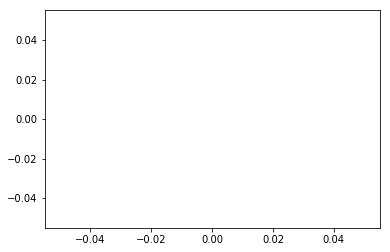

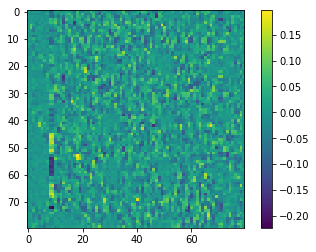

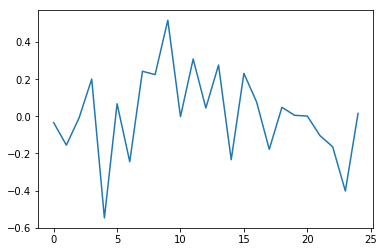

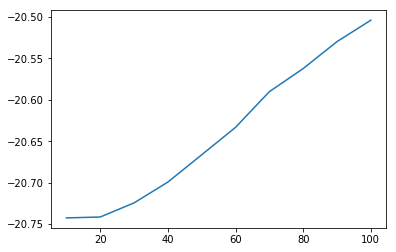

[-20.0, -19.0, -21.0, -21.0, -21.0]


In [9]:
show_stats('revision_25')

In [96]:
# make a video
agent = rl.Agent('revision v1')
agent.train(render = True)

[2017-09-12 16:17:26,351] Making new env: Pong-v0


Pickling up 'revision v1' from episode 6200...


In [ ]:
[ ] Create script to re run evaluations (deterministically and non determinstically)  Also try 'don't move threshold', 
as I think the algorithm uses p=0.5 to 'stand still'

[ ] revision 2... use explore / exploit tradeoff (change over time)  Beta (alpha = beta = conf) should work.  
confidence = 1 is uniform, confidence = 100 is close to deterministic

[ ] make a nice dashboard... maybe a nice web based one?
[ ] include 'cooking' time.  Would be nice to know how long these take to get to their trained state. 
[ ] create an evaluation script that shows distribution of steps and scores etc.
[ ] graph deterministic / normal evalulation
[ ] weights over time gif
[ ] script to setup net from command line, and another to just train a net by name (load config from file)